Context: It is a data breach related sample dataset. covers some events from 2017 to early 2019.

Analysis Process: Run the whole data preparation, data exploration, descriptive analysis, and NLP analysis.

Key takeaways: Per the sample data analysis, since a large portion of data breach caused by internal poor security -- A general recommendation is to focus on enhance internal database security, and improve internal data management process.

In [1]:
import numpy as np
import pandas as pd
import time
import re
import unicodedata

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import requests
from bs4 import BeautifulSoup

# Sklearn Imports -used Sklearn here (used Gensim in project one)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# NLP Imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# WordCloud and Other Dependencies
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### $\color{blue}{\text{Part One: Data Preparation}}$

##### $\color{blue}{\text{1.1 Data Import and Basic Setup}}$

In [92]:
from google.colab import files
uploaded = files.upload()

Saving data_v1.xlsx to data_v1.xlsx


In [93]:
df = pd.read_excel('data_v1.xlsx', engine='openpyxl')
df.head(2)

,YEAR,records_lost,description,industry,METHOD,sensitive_rate,Unnamed: 6,records_2,source_One,Source_two
0,2019,36900000,ShareThis was part of the theft of 617 million...,web,hacked,1,NaN,NaN,https://www.theregister.co.uk/2019/02/11/620_m...,NaN
1,2019,25200000,HauteLook was part of the theft of 617 million...,retail,hacked,1,NaN,NaN,https://www.theregister.co.uk/2019/02/11/620_m...,NaN


In [94]:
# Standardize the text columns title to lowercase
df.columns=df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            99 non-null     int64  
 1   records_lost    99 non-null     object 
 2   description     99 non-null     object 
 3   industry        99 non-null     object 
 4   method          99 non-null     object 
 5   sensitive_rate  99 non-null     int64  
 6   unnamed: 6      0 non-null      float64
 7   records_2       13 non-null     float64
 8   source_one      99 non-null     object 
 9   source_two      6 non-null      object 
dtypes: float64(2), int64(2), object(6)
memory usage: 7.9+ KB


In [95]:
df = df.drop_duplicates()
len(df)

99

##### $\color{blue}{\text{1.2 Data Tranformation}}$

In [96]:
# Data type tranformation
col_to_convert=['year','records_lost','sensitive_rate','records_2']
df[col_to_convert]=df[col_to_convert].apply(lambda x:pd.to_numeric(x,errors='coerce')).astype('Int32')

In [97]:
# Handling missing values
# Did not transform 'M' and '<' to numerical values. as the impacted volumn is low (2%). Used median for the transfer.
median_value=df['records_lost'].median()
df['records_lost']=df['records_lost'].fillna(median_value)

In [98]:
# Drop redundant columns

# Check for 'records_2' and its relation with 'records_lost'|
# Check result: 12 match, 1 mis-match, the rest 87% are null
# Decision: Drop it as not much value added.

match_check=(df['records_2'].notna()) & (df['records_2']==df['records_lost'])
same_count=match_check.sum()
diff_count=((df['records_2'].notna())& (~match_check)).sum()
null_count=df['records_2'].isna().sum()

# Print the summary
print(f"{same_count} values same as 'records_lost', {diff_count} value is different, {null_count} are null ")

# Drop the 'displayed records' column as all above check are clear
if same_count+diff_count+null_count==len(df):
    df.drop(columns=['records_2'], inplace=True)

12 values same as 'records_lost', 1 value is different, 86 are null 


##### $\color{blue}{\text{1.3 Data Cleaning}}$

In [99]:
df['sensitive_rate'].unique()

<IntegerArray>
[1, 2, 3, 4, 5, 7]
Length: 6, dtype: Int32

In [100]:
# Cap all values greater than 5 to 5
df['sensitive_rate']=df['sensitive_rate'].clip(upper=5)

In [101]:
df['unnamed: 6'].value_counts() # no input
df=df.drop(['unnamed: 6'], axis=1)

##### $\color{blue}{\text{1.4 Final Data Preparation}}$

In [102]:
# Save a copy of cleaned data
df.to_csv('output.csv', index=False)

In [103]:
df.head(2)

,year,records_lost,description,industry,method,sensitive_rate,source_one,source_two
0,2019,36900000,ShareThis was part of the theft of 617 million...,web,hacked,1,https://www.theregister.co.uk/2019/02/11/620_m...,NaN
1,2019,25200000,HauteLook was part of the theft of 617 million...,retail,hacked,1,https://www.theregister.co.uk/2019/02/11/620_m...,NaN


### $\color{blue}{\text{Part Two: Data Exploration}}$

######  $\color{blue}{\text{2.1 Trends in Data Breaches: Count of Entities and Records Lost by Year}}$


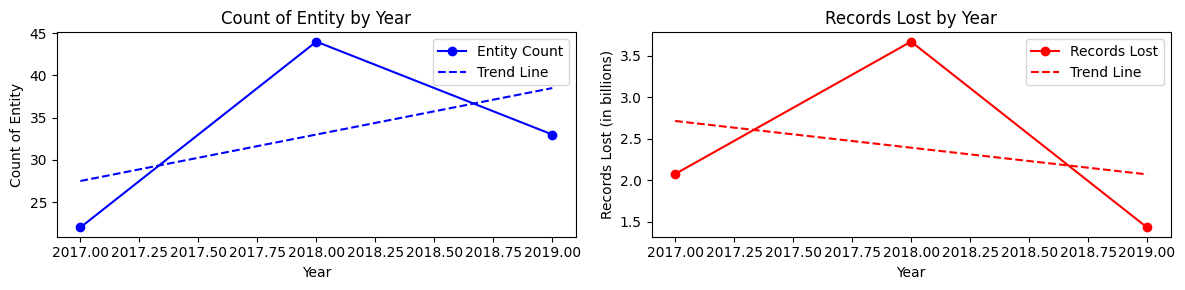

In [106]:
# Drop rows where 'year' is NaN
df_cleaned=df.dropna(subset=['year'])

# Summarize data by year
year_summary=df_cleaned.groupby('year').agg({'description': 'count', 'records_lost': 'sum'}).reset_index()

year_summary['records_lost'] = year_summary['records_lost'] / 1e9 # Converts to billions

# Create subplots for line chart
fig,axes=plt.subplots(1, 2, figsize=(12, 3))

# Function to plot and add trendline
def plot_with_trend(ax, x, y, color, label, set_ylabel, title):

  # Ensure x and y are numeric and drop NaNs
  x = pd.to_numeric(x, errors='coerce')
  y = pd.to_numeric(y, errors='coerce')
  valid_indices = ~x.isna() & ~y.isna()
  x, y = x[valid_indices].reset_index(drop=True).astype(float), y[valid_indices].reset_index(drop=True).astype(float)

  # plotting
  ax.plot(x, y, marker='o', linestyle='-', color=color, label=label)
  ax.set_xlabel('Year')
  ax.set_ylabel(set_ylabel)
  ax.set_title(title)

  # Add trend line
  z=np.polyfit(x, y, 1)  # Linear fit
  p=np.poly1d(z)
  ax.plot(x, p(x), linestyle='--', color=color, label='Trend Line')

  ax.legend()

# Plotting count of entities by year
plot_with_trend(axes[0], year_summary['year'], year_summary['description'], 'b', 'Entity Count', 'Count of Entity', 'Count of Entity by Year')

# Plotting records lost by year
plot_with_trend(axes[1], year_summary['year'], year_summary['records_lost'], 'r', 'Records Lost', 'Records Lost (in billions)','Records Lost by Year')

# Adjust layout
plt.tight_layout()
plt.show()

# Takeaways: intended to show the trend line through time. Reference only(as data only covers 2017- early 2019 here).

######  $\color{blue}{\text{2.2  Analysis of Data Breach Methods: Count of Entities and Records Lost}}$

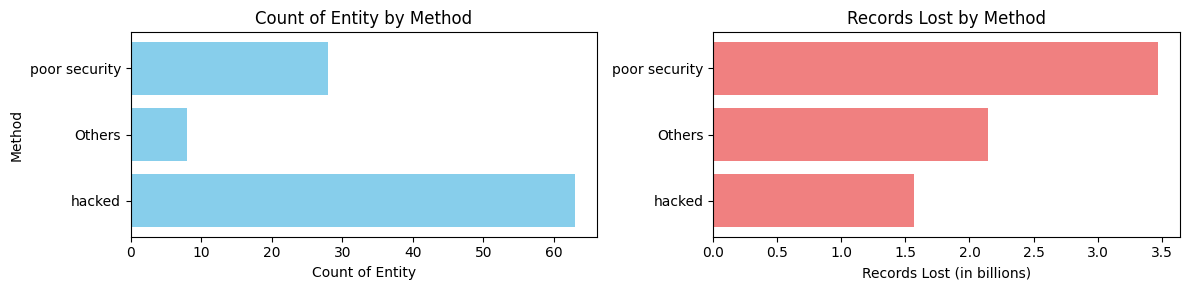

In [110]:
# Group data by 'method' and calculate count of entity and sum of records lost
method_summary=df.groupby('method').agg({'description': 'count', 'records_lost': 'sum'}).reset_index()

method_summary['records_lost'] = method_summary['records_lost'] / 1e9 # Converts to billions

# Sort the data in descending order based on 'records lost'
method_summary_sorted=method_summary.sort_values(by='records_lost', ascending=False)

# Create subplots for side-by-side charts
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(12, 3))

# Plotting count of entities
ax1.barh(method_summary_sorted['method'], method_summary_sorted['description'], color='skyblue')
ax1.set_xlabel('Count of Entity')
ax1.set_ylabel('Method')
ax1.set_title('Count of Entity by Method')
ax1.invert_yaxis()

# Plotting records lost in sorted order
ax2.barh(method_summary_sorted['method'], method_summary_sorted['records_lost'], color='lightcoral')
ax2.set_xlabel('Records Lost (in billions)')
ax2.set_title('Records Lost by Method')
ax2.invert_yaxis()

plt.tight_layout()
plt.show();

# Takeaways: More entities been hacked, in terms of records lost, poor security cause more demage (per sample dataset, may diff from actual)

### $\color{blue}{\text{Part Three: Descriptive Analysis}}$

###### $\color{blue}{\text{3.1 Data Distribution and Correlation: Records Lost, Data Sensitivity}}$

In [111]:
# Descriptive Statistics:
df[['records_lost','sensitive_rate']].describe()

,records_lost,sensitive_rate
count,99.0,99.0
mean,72574435.333333,2.292929
std,206918014.180962,1.319033
min,36000.0,1.0
25%,1485000.0,1.0
50%,8460000.0,2.0
75%,36450000.0,4.0
max,1233000000.0,5.0


In [112]:
# Correlation Analysis:
correlation = df[['records_lost','sensitive_rate']].corr()
correlation

# 0.125 indicates a very weak positive correlation.

,records_lost,sensitive_rate
records_lost,1.000000,0.124683
sensitive_rate,0.124683,1.000000


###### $\color{blue}{\text{3.2 Outlier Investigation of Records Lost}}$

Total Count of Outliers in Records Lost: 14


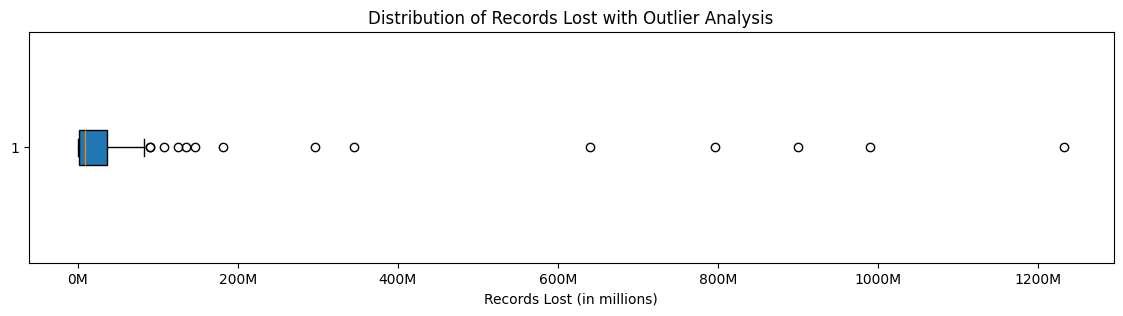

In [139]:
# Outlier Investigation:
Q1 = df['records_lost'].quantile(0.25)
Q3 = df['records_lost'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['records_lost'] < (Q1 - 1.5 * IQR)) | (df['records_lost'] > (Q3 + 1.5 * IQR))]
print(f'Total Count of Outliers in Records Lost: {len(outliers)}')

# Drop NaN values to avoid any issues in plotting
df_non_null = df['records_lost'].dropna()

# Create the boxplot for the 'records lost' column
plt.figure(figsize=(14,3))
plt.boxplot(df_non_null, vert=False, patch_artist=True)
plt.title('Distribution of Records Lost with Outlier Analysis')
plt.xlabel('Records Lost (in millions)')

# Set x-axis formatter to display values in millions
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x * 1e-6:.0f}M'))

plt.show()

###### $\color{blue}{\text{ 3.3  Sector Analysis of Records Lost: Descriptive Statistics and Distribution (Top 5 Sectors)}}$

In [114]:
# Group by 'sector' and calculate descriptive statistics for 'records lost'
sector_summary = df.groupby('industry')['records_lost'].describe()

# Convert to DataFrame and round values to make it more readable
sector_summary_df = sector_summary.reset_index().round(2)

# Sort by 'count' or any other relevant metric (e.g., mean or max)
sector_summary_sorted = sector_summary_df.sort_values(by='count', ascending=False)

sector_summary_sorted.head(5)


,industry,count,mean,std,min,25%,50%,75%,max
11,web,33.0,86223678.79,234889317.72,36000.0,7200000.0,16200000.0,45000000.0,1233000000.0
1,app,16.0,56424881.25,81851856.08,278100.0,1732500.0,15300000.0,94500000.0,297000000.0
7,retail,11.0,47225454.55,100234370.89,90000.0,3150000.0,8460000.0,36900000.0,344700000.0
5,healthcare,7.0,3310714.0,4421431.34,67500.0,78749.0,1350000.0,5445000.0,10710000.0
2,financial,6.0,135243000.0,323984371.62,243000.0,303750.0,922500.0,9810000.0,796500000.0


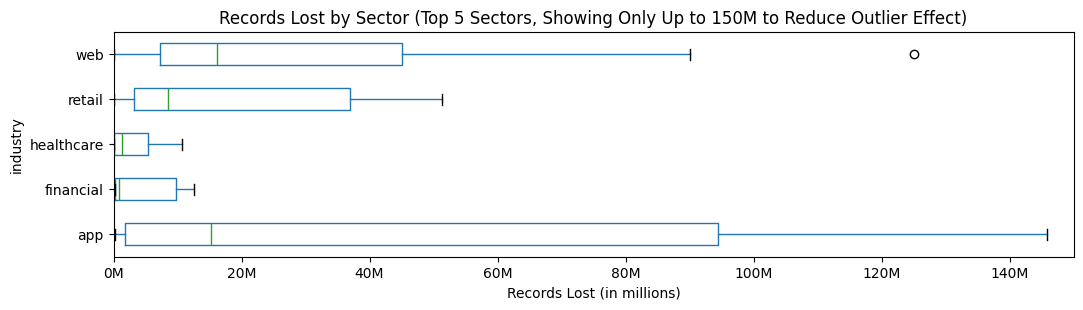

In [115]:
# Get the top 5 sectors based on the total count of entities
top_5_sectors = sector_summary_sorted['industry'][:5]

# Filter the DataFrame to include only the top 5 sectors
df_filtered_top5 = df[df['industry'].isin(top_5_sectors)]

# Create the boxplot for the filtered data
df_filtered_top5.boxplot(column='records_lost', by='industry', vert=False, figsize=(12, 3))
plt.title('Records Lost by Sector (Top 5 Sectors, Showing Only Up to 150M to Reduce Outlier Effect)')
plt.suptitle('')
plt.xlabel('Records Lost (in millions)')
plt.xlim(0,150_000_000)

# Optionally format the x-axis labels to show values in millions
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x * 1e-6:.0f}M'))

plt.grid(False)
plt.show()

### $\color{blue}{\text{Part Four: NLP Analysis}}$

##### $\color{blue}{\text{4.1 Scraping Article Content from URLs}}$

In [116]:
def get_article_content(url):
    try:
        # Send a request to fetch the HTML content of the page
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise an exception if the request failed

        # Parse the HTML using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract article content: Look for tags that commonly contain article text, e.g., <p>, <div>
        paragraphs = soup.find_all('p')
        article_text = " ".join([para.get_text() for para in paragraphs])

        return article_text
    except requests.RequestException as e:
        return None

In [117]:
# Create new columns to store the scraped articles

df['article_source'] = None

# Iterate through the DataFrame and fetch the content for each URL
for index, row in df.iterrows():
    if pd.notna(row['source_one']):
        df.at[index, 'article_source'] = get_article_content(row['source_one'])

    else:
        df.at[index, 'article_source'] = get_article_content(row['source_two'])

    time.sleep(1)  # Wait for 1 second between requests

In [118]:
# Count the number of successfully scraped articles
scraped_count = df['article_source'].notna().sum()

print(f'Total articles successfully scraped: {scraped_count}')

Total articles successfully scraped: 61


##### $\color{Blue}{\text{4.2 LDA (Latent Dirichlet Allocation)}}$

###### $\color{blue}{\text{4.2.1 Text Preprocessing Pipeline for Articles}}$

In [120]:
# Covers the initial part involving cleaning text, removing stopwords, tokenizing, and stemming

# Drop empty rows
df_articles = df[df['article_source'].apply(lambda x: x is not None and len(x) > 0)].copy()

# Clean text
def clean_text(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8')
    x = x.lower()
    x = re.sub(r"[^\w\s]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

df_articles['article_source'] = df_articles['article_source'].apply(clean_text)

# Remove stopwords and tokenize
extended_stopwords = set(stopwords.words('english')).union({'said', 'year', 'include'})
df_articles['article_source'] = df_articles['article_source'].apply(lambda x: [word for word in word_tokenize(x) if word not in extended_stopwords])

# Stemming
ps = PorterStemmer()
df_articles['article_source']  = df_articles['article_source'] .apply(lambda tokens: [ps.stem(token) for token in tokens])

# Final output
print(df_articles[['industry','method','article_source' ]].head(2))

     industry         method  \
3   financial         hacked   
5  healthcare  poor security   

                                      article_source  
3  [pay, park, ticket, municip, water, tax, never...  
5  [quest, diagnost, one, biggest, blood, test, p...  


###### $\color{blue}{\text{4.2.2 Topic Modeling with LDA}}$

In [121]:
# Focuses on filtering articles, creating a Document-Term Matrix, running LDA, and extracting top words for each topic.
# USED SKLEARN here for the vectorization and LDA process (to try for diff approach, as coherence score for further process is not intended in this script)

# Filters articles based on given criteria.
def filter_articles(df_articles, filter_column, filter_value):
    return df_articles[df_articles[filter_column].isin(filter_value)]['article_source']

# Vectorizes the articles into a Document-Term Matrix.
def create_document_term_matrix(articles):
    articles = articles.apply(lambda tokens: ' '.join(tokens))
    vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
    document_term_matrix = vectorizer.fit_transform(articles)
    print(f"Shape of the Document-Term Matrix: {document_term_matrix.shape}\n")
    return document_term_matrix, vectorizer

# Runs LDA on the Document-Term Matrix.
def run_lda(document_term_matrix, n_components=10, random_state=42):
    lda_model = LatentDirichletAllocation(n_components=n_components, random_state=random_state)
    lda_model.fit(document_term_matrix)
    return lda_model

# Extracts and prints the top words for each topic.
def extract_topics(lda_model, vectorizer, n_top_words=10):
    words = vectorizer.get_feature_names_out()
    topics = []
    for idx, topic in enumerate(lda_model.components_):
        top_words = [words[i] for i in topic.argsort()[-n_top_words:]]
        topics.append(top_words)
        print(f"Topic {idx + 1}: {top_words}")
    return topics

# Full LDA analysis workflow. Returns a list of keywords for each topic.
def lda_analysis(df, filter_column, filter_value, n_topics=10, random_state=40):
    filtered_articles = filter_articles(df, filter_column, filter_value)
    doc_term_matrix, vectorizer = create_document_term_matrix(filtered_articles)
    lda_model = run_lda(doc_term_matrix, n_components=n_topics, random_state=random_state)
    return extract_topics(lda_model, vectorizer)

##### $\color{blue}{\text{4.3 Topic Analysis of Articles Using LDA and Word Clouds - Two Versions of 'Poor Security'}}$

In [136]:
# Generates and displays a word cloud from topic keywords.
def generate_word_cloud_from_topics(topic_keywords_list, title=''):
    # Flatten the list of keywords
    all_keywords = [word for sublist in topic_keywords_list for word in sublist]

    # Create a frequency dictionary
    word_freq = {}
    for word in all_keywords:
        word_freq[word] = word_freq.get(word, 0) + 1

    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [137]:
# Scenario 1 & 2: Cross verify (two diff random state) for 'poor security' method

# Scenario 1: Method is 'poor security'
topics_scenario_1 = lda_analysis(df_articles, filter_column='method', filter_value=['poor security'])
print("\n")

# Scenario 2: Method is 'poor security', cross verify with different random state
topics_scenario_2 = lda_analysis(df_articles, filter_column='method', filter_value=['poor security'], random_state=70)

Shape of the Document-Term Matrix: (21, 1186)

Topic 1: ['increas', 'damag', 'grant', 'entiti', 'determin', 'result', '19', 'march', 'area', 'cyber']
Topic 2: ['articl', 'password', 'use', 'issu', 'email', 'peopl', 'websit', 'inform', 'locat', 'user']
Topic 3: ['custom', 'web', 'need', 'hacker', 'compani', 'record', 'access', 'american', 'use', 'site']
Topic 4: ['david', '000', 'http', 'ip', 'voic', 'integr', 'comput', 'men', 'till', 'en']
Topic 5: ['expos', 'address', 'access', 'email', 'googl', 'file', 'site', 'inform', 'facebook', 'user']
Topic 6: ['increas', 'damag', 'grant', 'entiti', 'determin', 'result', '19', 'march', 'area', 'cyber']
Topic 7: ['polit', 'util', 'ident', 'compani', 'texa', 'bank', 'govern', 'number', 'databas', 'inform']
Topic 8: ['increas', 'damag', 'grant', 'entiti', 'determin', 'result', '19', 'march', 'area', 'cyber']
Topic 9: ['report', 'like', 'site', 'inform', 'number', 'compani', 'breach', 'record', 'account', 'custom']
Topic 10: ['instagram', 'ai', 'exp

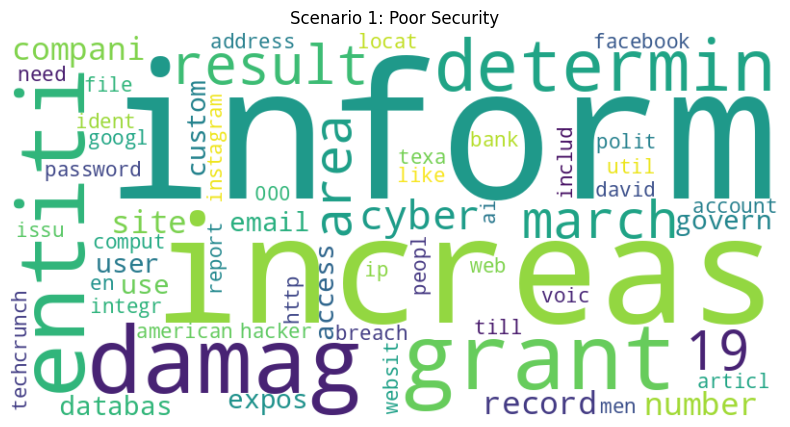

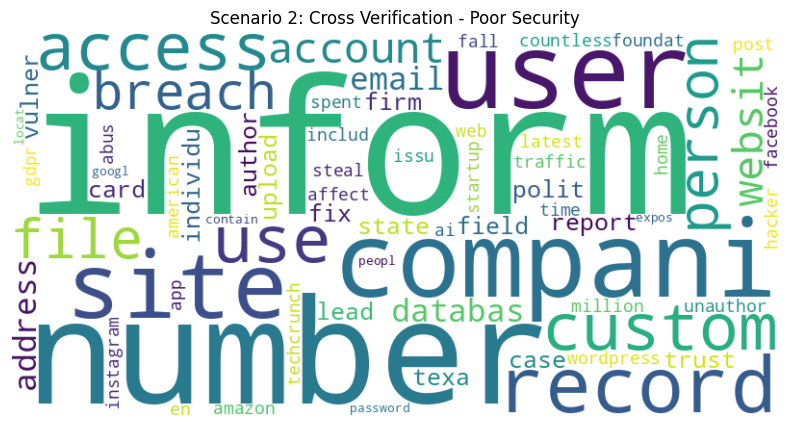

In [138]:
# Wordcloud comparation for scenario_1 and 2: Based on 'Poor Securiry'
generate_word_cloud_from_topics(topics_scenario_1, title='Scenario 1: Poor Security')
print('\n\n')
generate_word_cloud_from_topics(topics_scenario_2, title='Scenario 2: Cross Verification - Poor Security')